# Análisis de datos : Kickstarter

## Ejercicio de reproducibilidad en Ciencia de Datos


### Universidad de Sonora / Maestría en Ciencia de Datos
### Curso de Programación para Ciencia de Datos
#### Alumna: Brenda Leyva Amaya


El análisis que se desarrolla aquí busca responder las siguientes preguntas:

* **1.** ¿Hay algún impacto de la duración de la campaña en el grado de éxito?


* **2.** ¿Cuál es la relación entre la meta del dinero a recaudar y el grado de éxito?
  
  **a)** Distribución de la meta con respecto al monto reunido.
  
*Este análisis fue originalmente diseñado por:
Wanyi Chen, Mila Korobkina, Caroline Lu y Saumya Ray
de la Universidad de Carolina del Norte*

### Primero cargamos las librerías a utilizar

In [1]:
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dfply
import datetime
from scipy import stats
%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 100

### Lectura del archivo

In [2]:
data = pd.read_csv("ks-projects-201801.csv")

In [3]:
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [4]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


El dataset examina 14 atributos de las campañas de Kickstarter. Estos atributos son: Nombre de la campaña, categoría y subcategoría, moneda, fecha límite, meta económica, fecha de lanzamiento, dinero aportado, estado de éxito o fracaso, cantidad de patrocinadores, país, suma de aportaciones en dólares, y suma real de aportaciones en dólares, y la meta real en dólares. 

### Exploración inicial y limpieza de datos

#### Una vista general al dataset y sus características con ayuda de la función resumetable.

In [5]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [6]:
resumetable(data)

Dataset Shape: (378661, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,ID,int64,0,378661,1000002330,1000003930,1000004038,18.53
1,name,object,4,375764,The Songs of Adelaide & Abullah,Greeting From Earth: ZGAC Arts Capsule For ET,Where is Hank?,18.51
2,category,object,0,159,Poetry,Narrative Film,Narrative Film,6.26
3,main_category,object,0,15,Publishing,Film & Video,Film & Video,3.57
4,currency,object,0,14,GBP,USD,USD,1.29
5,deadline,object,0,3164,2015-10-09,2017-11-01,2013-02-26,11.30
6,goal,float64,0,8353,1000,30000,45000,6.65
7,launched,object,0,378089,2015-08-11 12:12:28,2017-09-02 04:43:57,2013-01-12 00:20:50,18.53
8,pledged,float64,0,62130,0,2421,220,11.48
9,state,object,0,6,failed,failed,failed,1.51


#### Algunos ajustes

Los campos de deadline (fecha límite) y de launched (fecha de lanzamiento) se tienen guardadas como objetos, ID se maneja mejor como string, a continuación las redefinimos como el tipo correcto:

In [7]:
data['deadline'] = data['deadline'].astype('datetime64')
data['launched'] = data['launched'].astype('datetime64')
data['ID'] = data['ID'].astype('str')

La columna usd_pledged tiene una cantidad significativa de datos faltantes, es posible remover esta columna y continuar el análisis ya que se trabajará con usd_pledged_real para el caso de esta información. Adicionalmente, se pueden eliminar otras columnas que no se utilizarán.

In [8]:
data = data >> dfply.drop('usd pledged', 'currency', 'goal', 'pledged', 'category')

Y llenar los 4 datos faltantes en el campo de 'name'.

In [9]:
data = data.fillna('NA')

In [10]:
data.isna().sum()

ID                  0
name                0
main_category       0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

Lo primero que necesitamos establecer es la duración de las campañas, ya que se cuenta con los dos datos que nos permiten obtener esta información. La duración de la campañana estara dada por la fecha de lanzamiento y la fecha límite. Será necesario crear una nueva columna que contenga este dato que necesitamos.

In [11]:
data = data >> dfply.mutate(duration = data.deadline - data.launched)

In [12]:
data.head()

,ID,name,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58 days 11:47:32
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59 days 19:16:03
2,1000004038,Where is Hank?,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44 days 23:39:10
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29 days 20:35:49
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55 days 15:24:57


De la nueva columna que obtuvimos nos quedaos unicamente con el número de días. A continuación se modifica con ayuda de la funcion split.

In [13]:
data['duration'] = data['duration'].astype('str')

In [14]:
data.duration = data.duration.str.split(expand=True)

In [15]:
data.duration = data.duration.astype('int')

In [16]:
data.duration

0         58
1         59
2         44
3         29
4         55
          ..
378656    29
378657    26
378658    45
378659    30
378660    27
Name: duration, Length: 378661, dtype: int32

Una columna que nos resultará útil es aquella que indique si se alcanzó la meta de recaudación o se sobrepasó, indicando esto el exito de la campaña.

In [17]:
data['diff'] = data.usd_goal_real - data.usd_pledged_real

In [18]:
data['diff']

0          1533.95
1         27579.00
2         44780.00
3          4999.00
4         18217.00
            ...   
378656    49975.00
378657     1345.00
378658    14980.00
378659    14800.00
378660     1476.00
Name: diff, Length: 378661, dtype: float64

Finalmente modifiquemos algunos nombres de columnas para facilitar su manejo:

In [19]:
data.rename(columns = {'main_category':'category', 'usd_pledged_real':'pledged', 'usd_goal_real':'goal'}, inplace = True)

Ahora que hemos hecho algunas modificaciones revisemos el dataset obtenido.

In [20]:
data.head()

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59,27579.00
2,1000004038,Where is Hank?,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44,44780.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29,4999.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55,18217.00


In [21]:
data.describe()

,backers,pledged,goal,duration,diff
count,378661.000000,3.786610e+05,3.786610e+05,378661.000000,3.786610e+05
mean,105.617476,9.058924e+03,4.545440e+04,33.481122,3.639548e+04
std,907.185035,9.097334e+04,1.152950e+06,65.909172,1.156026e+06
min,0.000000,0.000000e+00,1.000000e-02,0.000000,-1.983899e+07
25%,2.000000,3.100000e+01,2.000000e+03,29.000000,-2.000000e+02
50%,12.000000,6.243300e+02,5.500000e+03,29.000000,1.975000e+03
75%,56.000000,4.050000e+03,1.550000e+04,36.000000,9.999000e+03
max,219382.000000,2.033899e+07,1.663614e+08,16738.000000,1.663614e+08


#### Detección de outliers

Una vez obtenida la tabla descriptiva general, se puede ver que en el campo de duración de las campañas hay un valor máximo que parece ser átipico o un posible error. Hechamos un vistazo a los valores únicos de este campo:

In [22]:
data.duration.unique()

array([   58,    59,    44,    29,    55,    34,    19,    27,    14,
          30,    39,    10,    24,    47,    40,    28,    41,    42,
          52,    33,    21,    16,    43,    45,    31,    65,    48,
          35,    60,    37,    36,    17,    32,    13,     4,    54,
          25,    50,    26,    18,    23,    51,    20,    15,    49,
          86,    22,    38,    12,    11,     9,    56,    82,     7,
          53,    89,     5,    46,    70,     8,    61,     0,     6,
          72,    57,    63,    90,     2,    88, 14866,    69,    68,
          71,     3,    67,    84,    66,    73,    80,    83,    87,
          74,     1,    64,    75,    62,    79,    78,    85,    77,
          81,    76,    91, 14834, 14749, 14760, 14732, 14708, 16738])

A excepción de unos pocos valores, la gran mayoría existen debajo de 100, así que veamos a detalle esos casos arriba de 100 días.

In [23]:
data >> dfply.mask(data.duration > 100)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,2010-09-15,1970-01-01 01:00:00,canceled,0,US,0.0,5000.00,14866,5000.00
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,2010-08-14,1970-01-01 01:00:00,canceled,0,US,0.0,15000.00,14834,15000.00
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,2010-05-21,1970-01-01 01:00:00,canceled,0,US,0.0,700.00,14749,700.00
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,2010-06-01,1970-01-01 01:00:00,canceled,0,US,0.0,4000.00,14760,4000.00
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,2010-05-04,1970-01-01 01:00:00,canceled,0,US,0.0,10000.00,14732,10000.00
273779,462917959,Identity Communications Infographic (Canceled),Design,2010-04-10,1970-01-01 01:00:00,canceled,0,US,0.0,500.00,14708,500.00
319002,69489148,Student Auditions Music 2015,Publishing,2015-10-31,1970-01-01 01:00:00,suspended,0,CH,0.0,1905.97,16738,1905.97


Aquí se confirma que estos valores son errores en el dataset ya que no pueden existir campañas del año 1970. Por lo que se procede a eliminar esas filas.

In [24]:
data = data >> dfply.mask(data.duration < 100)

In [25]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,378654.00000,378654.00000,378654.00000,378654.00000,378654.00000
mean,105.61943,9059.09154,45455.14377,33.20342,36396.05222
std,907.19331,90974.17566,1152960.69897,12.79317,1156036.65121
min,0.00000,0.00000,0.01000,0.00000,-19838986.27000
25%,2.00000,31.00000,2000.00000,29.00000,-200.00000
50%,12.00000,624.46500,5500.00000,29.00000,1975.00000
75%,56.00000,4050.00000,15500.00000,36.00000,9999.00000
max,219382.00000,20338986.27000,166361390.71000,91.00000,166361390.71000


Ahora tenemos un valor de duración máxima de 91 días para las camapañas. Sin embargo, un dato que puede ser también problemático son aquellas que tienen una duración de 0 días. A continuación analizamos un poco más a fondo esos casos.

In [26]:
no_duration = data >> dfply.mask(data.duration < 1) >> dfply.arrange('pledged')
no_duration

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
121499,1617139964,Get Patty's ass to the Burgh,Film & Video,2015-04-04,2015-04-03 03:45:35,failed,0,US,0.00,10000.00,0,10000.00
103483,1526194584,A New Handbag,Fashion,2016-04-21,2016-04-20 12:55:51,failed,0,US,0.00,1000.00,0,1000.00
111819,156802730,Ideal Playing Cards Sticker Seals - Black & Go...,Games,2016-01-05,2016-01-04 16:41:46,failed,0,US,0.00,1.00,0,1.00
118408,1601585086,Clock in the shape of an Apple,Design,2015-05-01,2015-04-30 18:20:44,failed,0,US,0.00,1000.00,0,1000.00
128829,165405157,A radio/TV station showcasing underground musi...,Music,2015-08-14,2015-08-13 18:40:44,failed,0,GB,0.00,23452.16,0,23452.16
...,...,...,...,...,...,...,...,...,...,...,...,...
20368,1103482181,The Next Winged Queen (number 4!),Art,2016-04-02,2016-04-01 08:38:27,failed,86,US,7670.00,8888.00,0,1218.00
268704,43736794,Another Fucking Warhol Production,Dance,2017-05-11,2017-05-10 18:15:14,successful,161,US,7740.26,5000.00,0,-2740.26
83221,1423239824,Next Art Nouveau Winged Queen (Number 5!) by E...,Art,2017-04-02,2017-04-01 05:49:05,failed,71,US,8385.00,8888.00,0,503.00
377311,993249553,1st Annual Brian Kesinger Christmas Ornament,Art,2017-12-15,2017-12-14 09:01:39,successful,59,US,9244.00,1000.00,0,-8244.00


In [27]:
no_duration.state.value_counts()

failed        57
successful    35
canceled       9
suspended      1
Name: state, dtype: int64

Para continuar el análisis se decide eliminar estos registros.

In [28]:
data = data >> dfply.mask(data.duration > 0)

Adicionalmente se inspeccionan los casos que no tuvieron patrocinadores.

In [29]:
no_backers = data >> dfply.mask(data.backers < 1)
no_backers.head()

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58,1533.95
10,100004721,Of Jesus and Madmen,Publishing,2013-10-09,2013-09-09 18:19:37,failed,0,CA,0.0,2406.39,29,2406.39
12,1000055792,The Cottage Market,Crafts,2014-10-02,2014-09-02 17:11:50,failed,0,US,0.0,5000.00,29,5000.00
13,1000056157,G-Spot Place for Gamers to connect with eachot...,Games,2016-03-25,2016-02-09 23:01:12,failed,0,US,0.0,200000.00,44,200000.00
26,1000103948,Superhero Teddy Bear,Crafts,2016-01-05,2015-12-06 20:09:06,failed,0,GB,0.0,17489.65,29,17489.65


In [30]:
no_backers.state.value_counts()

failed        38708
canceled      12025
undefined      3562
suspended       615
live            549
successful      105
Name: state, dtype: int64

Se decide que los casos que no tuvieron patrocinadores no pueden identificarse como exitosos, por lo que se procede a eliminar esos 105 registros.

In [31]:
delete = no_backers >> dfply.mask(no_backers.state == 'successful')

In [32]:
delete = delete.index

In [33]:
data.drop(delete, inplace=True)

Ahora, si el campo de diferencia es menor que cero entonces las campañas han alcanzado e incluso superado la meta económica propuesta, por lo que estas debería tener como estado indicado el de éxito o un estado distinto al fracaso. A continuación nos aseguramos de esto:

In [34]:
goal_passed = data >> dfply.mask(data['diff'] < 0)

In [35]:
goal_passed.state.value_counts()

successful    129766
undefined       1582
canceled         649
live             429
suspended        286
failed             4
Name: state, dtype: int64

In [36]:
goal_passed >> dfply.mask(goal_passed.state == 'failed')

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
16780,1085047405,"""Balance""",Music,2013-04-04,2013-03-05 10:55:56,failed,141,US,23020.01,23000.0,29,-20.01
58558,1297794474,Music Empowers - A Day with the Accende Ensemble,Music,2012-01-04,2011-11-07 15:20:24,failed,20,US,3087.50,3000.0,57,-87.50
216545,2103203254,The new face of Canadian Science Fiction,Publishing,2010-05-16,2010-03-18 04:35:31,failed,66,US,10797.00,10000.0,58,-797.00
298960,59246799,Key Wrench - Unlock Your Life!,Design,2013-10-04,2013-08-24 05:42:10,failed,208,US,6183.00,6000.0,40,-183.00


Se decide que estos registros introducen posible error en los datos y se eliminan.

In [37]:
delete1 = goal_passed >> dfply.mask(goal_passed.state == 'failed')
delete1 = delete1.index
data.drop(delete1, inplace=True)

Existen campañas con una meta económica igual o menor a 1 dólar, estas introducen un grado de ruido en el dataset y se ha tomado la decisión de continuar el análisis sin considerarlas:

In [38]:
data >> dfply.mask(data.goal < 2)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
363,1001685760,Wholesters- A new way to Whold your things!,Fashion,2011-05-29,2011-04-29 01:03:16,successful,3,US,566.00,1.00,29,-565.00
532,1002571103,3mm Aluminum Pick Plectrum,Music,2014-03-24,2014-02-22 23:28:33,successful,9,CA,18.12,0.91,29,-17.21
764,100372771,A Big Dream of a Little Man - Alex Oddman's De...,Music,2017-01-19,2016-12-20 22:01:21,canceled,1,US,7.00,1.00,29,-6.00
993,1005030157,Tons Of Music For A Buck!!!,Music,2015-08-15,2015-07-16 23:41:20,successful,13,US,113.00,1.00,29,-112.00
1865,1009620717,Tale Of Tails,Publishing,2015-05-02,2015-04-02 18:40:40,failed,0,US,0.00,1.00,29,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
376519,988997503,SpaceTop revealing a science mystery for high ...,Technology,2016-06-08,2016-05-09 19:03:27,successful,2,US,58.00,1.00,29,-57.00
376765,990431937,Anna Ash - Floodlights (album pre-order),Music,2016-09-01,2016-07-23 23:19:17,successful,68,US,1826.00,1.00,39,-1825.00
377441,993961188,SWEET LITTLE BITTER by BAD REED,Music,2017-05-20,2017-04-20 16:34:05,successful,42,CA,1485.22,0.74,29,-1484.48
378342,998486147,Half Bloods Series,Film & Video,2016-04-17,2016-03-17 03:57:51,failed,0,US,0.00,1.00,30,1.00


In [39]:
data = data >> dfply.mask(data.goal > 2)

In [40]:
data.state.value_counts()

failed        197609
successful    133483
canceled       38704
undefined       3562
live            2792
suspended       1833
Name: state, dtype: int64

### Distribución de los datos

Una parte importante en toda exploración de datos es conocer su distribución, esto es, obtener una idea general del comportamiento de una variable en específico. A continuación se producen los histogramas de las variables numéricas para poder observar de manera rápida sus respectivas distribuciones.

In [41]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,377983.00000,377983.00000,377983.00000,377983.00000,377983.00000
mean,105.73487,9064.14970,45240.16165,33.21682,36176.01195
std,907.94989,90943.79824,1142356.88907,12.77924,1145457.14041
min,0.00000,0.00000,2.23000,1.00000,-19838986.27000
25%,2.00000,31.00000,2000.00000,29.00000,-200.00000
50%,12.00000,625.00000,5500.00000,29.00000,1980.00000
75%,56.00000,4053.00500,15574.44000,36.00000,9999.00000
max,219382.00000,20338986.27000,166361390.71000,91.00000,166361390.71000


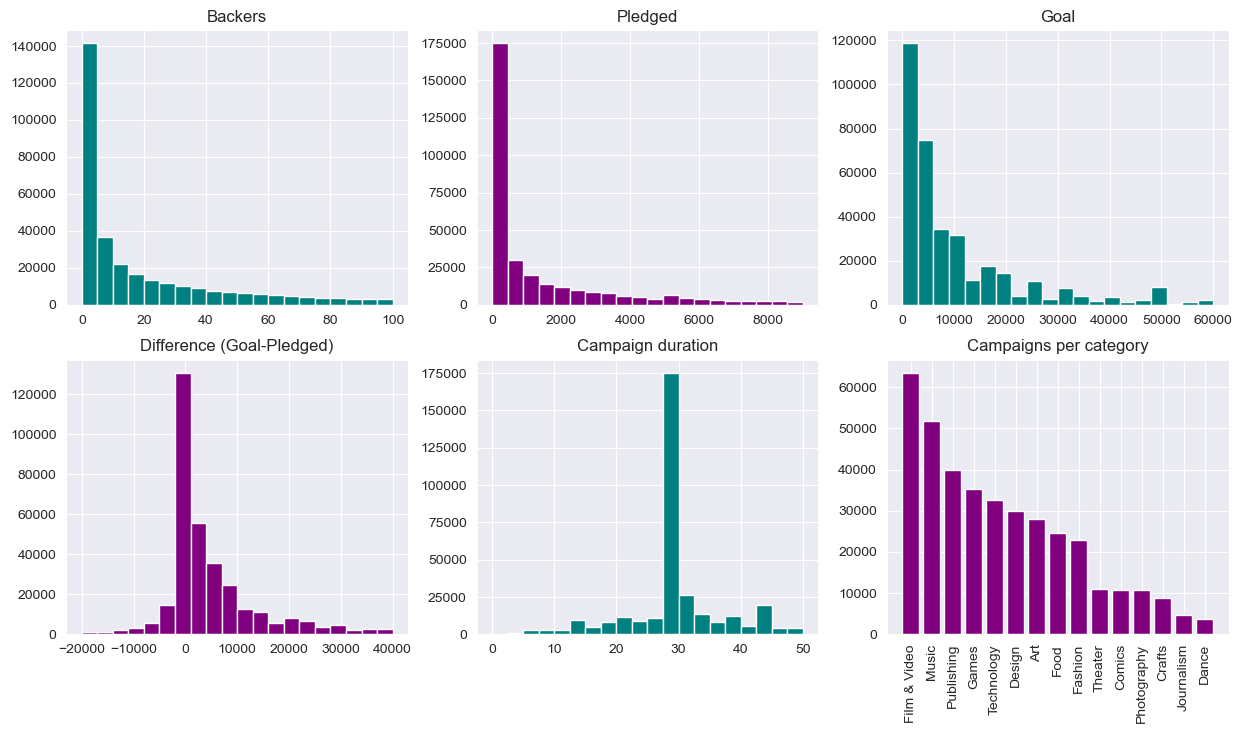

In [42]:
topc = data.category.value_counts()
x = topc.index.tolist()
y = topc

fig, axs = plt.subplots(ncols = 3, nrows = 2)
fig.set_figwidth(15)
fig.set_figheight(8)
axs[0,0].hist(data.backers, range = (0,100), bins = 20, color = 'teal')
axs[0,0].set_title('Backers')
axs[0,1].hist(data.pledged, range = (0,9000), bins = 20, color = 'purple')
axs[0,1].set_title('Pledged')
axs[0,2].hist(data.goal, range = (0,60000), bins = 20, color = 'teal')
axs[0,2].set_title('Goal')
axs[1,0].hist(data['diff'], range = (-20000,40000), bins = 20, color = 'purple')
axs[1,0].set_title('Difference (Goal-Pledged)')
axs[1,1].hist(data.duration, range = (0,50), bins = 20, color = 'teal')
axs[1,1].set_title('Campaign duration')
axs[1,2].bar(np.arange(len(x)), y, tick_label=x, color = 'purple')
axs[1,2].set_title('Campaigns per category')
plt.xticks(rotation=90);

#### De los gráficos anteriores podemos observar que:

* 1. La mayoría de las campañas se encuentran entre 0 y 20 patrocinadores.
* 2. Los apoyos tienden a estar debajo de los 2,000 dólares en total para la campaña, en la mayoría de los casos alrededor de 5,000 dolares los reunidos.
* 3. Las campañas tienen metas económicas mayormente en el rango entre 0 y 10,000 dólares.
* 4. En el caso de la diferencia entre la meta económica y el monto recaudado, las cantidades negativas del histograma indican campañas que superaron la meta, se puede observar una gran cantidad de campañas que caen dentro de cantidades negativas bajas, es decir, se aprecia en la gráfica que muchas campañas superan la meta por una cantidad relativamente pequeña de dólares.
* 5. La duración de las camapañas es por lo general de un mes o un poco menos. 
* 6. La categoría de Filmes y Video es la más utilizada, seguida la categoría de Música.

Con respecto al estado de las campañas, obtenemos el siguiente gráfico.

In [43]:
results = data.state.value_counts()

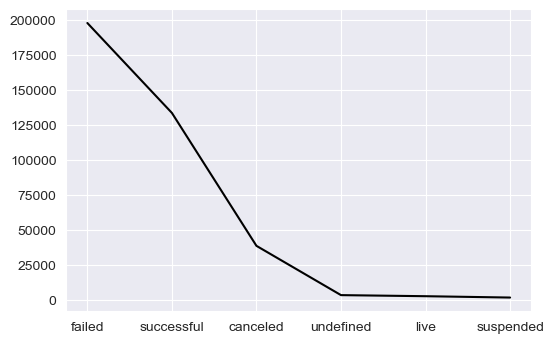

In [44]:
plt.plot(results, color = 'black');

Se observa una cantidad grande de campañas que han fallado. Sin embargo, también un grado considerable de éxito.

### Correlaciones

Otra parte importante a explorar es la posible correlación que pueda existir entre variables. Para ello tomemos sólo los datos de tipo númerico de nuestro dataset.

In [45]:
hm = data >> dfply.select(data.backers, data.pledged, data.goal, data.duration, data['diff'])

Y con este nuevo subset de datos obtengamos la matríz de correlación y el correspondiente mapa de calor:

In [46]:
hm.corr()

,backers,pledged,goal,duration,diff
backers,1.000000,0.753475,0.004588,-0.001682,-0.055246
pledged,0.753475,1.000000,0.005669,0.006870,-0.073741
goal,0.004588,0.005669,1.000000,0.023211,0.996843
duration,-0.001682,0.006870,0.023211,1.000000,0.022602
diff,-0.055246,-0.073741,0.996843,0.022602,1.000000


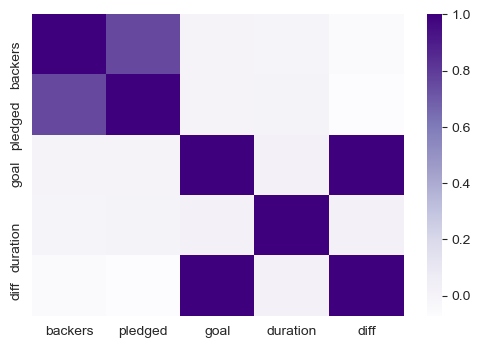

In [47]:
sns.heatmap(hm.corr(), cmap = 'Purples');

## 1. Impacto de la duración de la campaña en el grado de éxito

De la sección de correlación podemos establecer de manera preliminar que no parece existir una relación entre la duración de la campaña y otra variables como la cantidad de patrocinadores o el hecho de haber alcanzado o no la meta económica. Sin embargo, es posible explorar las características de las campañas en base a su duración y establecer hallazgos al respecto.

In [48]:
duration_1 = data >> dfply.mask(data.duration <= 7)
duration_2 = data >> dfply.mask((data.duration > 7) & (data.duration <= 22))
duration_3 = data >> dfply.mask((data.duration > 22) & (data.duration <= 37))
duration_4 = data >> dfply.mask((data.duration > 37) & (data.duration <= 52))
duration_5 = data >> dfply.mask((data.duration > 52) & (data.duration < 67))
duration_6 = data >> dfply.mask((data.duration > 67) & (data.duration <= 82))
duration_7 = data >> dfply.mask(data.duration > 82)

### Grupo 1 (≤ 7 días)

In [49]:
duration_1.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
146,1000598804,Gone In 61 Seconds,Games,2017-11-08,2017-11-03 13:44:35,failed,14,US,875.0,1000.0,4,125.0
233,1001020080,Wood Floor Fundraiser,Dance,2015-08-16,2015-08-11 17:13:30,successful,21,US,1205.0,1200.0,4,-5.0
631,100301891,Bridge of Sighs Short Film -- Part 2,Film & Video,2012-11-16,2012-11-08 19:55:58,successful,12,US,1405.0,1400.0,7,-5.0


In [50]:
duration_1.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,3810.00000,3810.00000,3810.00000,3810.00000,3810.00000
mean,42.85039,2242.89950,39956.92581,5.22441,37714.02631
std,453.00915,32362.25823,1034475.06107,1.61047,1034966.07815
min,0.00000,0.00000,3.00000,1.00000,-1304835.45000
25%,1.00000,4.00000,300.00000,4.00000,-157.49500
50%,6.00000,191.00000,970.21500,6.00000,150.00000
75%,21.00000,920.64500,3000.00000,6.00000,1728.13250
max,22834.00000,1364835.45000,55000000.00000,7.00000,55000000.00000


In [51]:
estados1 = duration_1.state.value_counts()
estados1

failed        1810
successful    1660
canceled       256
suspended       46
undefined       31
live             7
Name: state, dtype: int64

In [52]:
total1 = duration_1.backers.count()

In [53]:
porcentaje1 = (estados1/total1)*100
porcentaje1

failed        47.506562
successful    43.569554
canceled       6.719160
suspended      1.207349
undefined      0.813648
live           0.183727
Name: state, dtype: float64

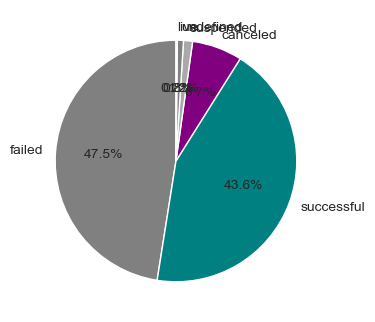

In [54]:
plt.pie(porcentaje1, labels=porcentaje1.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 2 (8-22 días)

In [55]:
duration_2.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,2014-12-21,2014-12-01 18:30:44,successful,16,US,1205.00,1000.0,19,-205.00
18,1000070642,Mike Corey's Darkness & Light Album,Music,2012-08-17,2012-08-02 14:11:32,successful,7,US,250.00,250.0,14,0.00
24,1000091520,The Book Zoo - A Mini-Comic,Comics,2014-11-12,2014-10-23 17:15:50,successful,66,US,701.66,175.0,19,-526.66


In [56]:
duration_2.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,39596.00000,39596.00000,39596.00000,39596.00000,39596.00000
mean,72.68565,5070.21663,22208.39670,16.51909,17138.18007
std,423.14379,49438.79480,1035758.42595,3.85277,1036844.87619
min,0.00000,0.00000,2.23000,8.00000,-7032757.00000
25%,2.00000,47.00000,811.52000,14.00000,-325.00000
50%,14.00000,678.75000,2500.00000,18.00000,11.00000
75%,47.00000,2979.12500,6000.00000,20.00000,2970.71500
max,43733.00000,7072757.00000,151395869.92000,22.00000,151395869.92000


In [57]:
estados2 = duration_2.state.value_counts()
estados2

successful    19379
failed        16645
canceled       2819
undefined       450
suspended       192
live            111
Name: state, dtype: int64

In [58]:
total2 = duration_2.backers.count()

In [59]:
porcentaje2 = (estados2/total2)*100
porcentaje2

successful    48.941812
failed        42.037074
canceled       7.119406
undefined      1.136478
suspended      0.484897
live           0.280331
Name: state, dtype: float64

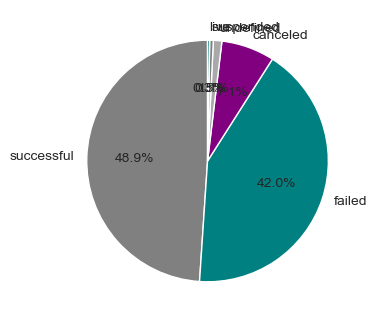

In [60]:
plt.pie(porcentaje2, labels=porcentaje2.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 3 (23-37 días)

In [61]:
duration_3.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.0,29,4999.0
5,1000014025,Monarch Espresso Bar,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.0,34,-2375.0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Design,2014-05-29,2014-04-24 18:14:43,canceled,58,US,8233.0,125000.0,34,116767.0


In [62]:
duration_3.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,243033.00000,243033.00000,243033.00000,243033.00000,243033.00000
mean,114.80750,9480.97301,32585.59175,29.34517,23104.61874
std,987.62481,93236.49500,791793.41103,2.13425,796263.03151
min,0.00000,0.00000,2.24000,23.00000,-19838986.27000
25%,2.00000,35.00000,2200.00000,29.00000,-243.00000
50%,13.00000,730.00000,5920.00000,29.00000,1955.00000
75%,63.00000,4686.00000,15869.99000,29.00000,9980.00000
max,219382.00000,20338986.27000,166361390.71000,37.00000,166361390.71000


In [63]:
estados3 = duration_3.state.value_counts()
estados3

failed        126487
successful     87257
canceled       24446
undefined       2354
live            1458
suspended       1031
Name: state, dtype: int64

In [64]:
total3 = duration_3.backers.count()

In [65]:
porcentaje3 = (estados3/total3)*100
porcentaje3

failed        52.045196
successful    35.903355
canceled      10.058716
undefined      0.968593
live           0.599919
suspended      0.424222
Name: state, dtype: float64

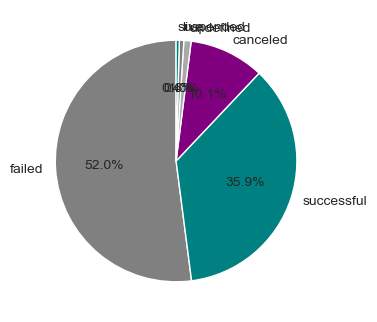

In [66]:
plt.pie(porcentaje3, labels=porcentaje3.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 4 (38-52 días)

In [67]:
duration_4.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
2,1000004038,Where is Hank?,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.0,44,44780.0
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Food,2016-03-17,2016-02-01 20:05:12,failed,40,US,453.0,25000.0,44,24547.0
13,1000056157,G-Spot Place for Gamers to connect with eachot...,Games,2016-03-25,2016-02-09 23:01:12,failed,0,US,0.0,200000.0,44,200000.0


In [68]:
duration_4.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,46586.00000,46586.00000,46586.00000,46586.00000,46586.00000
mean,134.52029,13603.30036,42377.37540,43.15348,28774.07504
std,1083.35199,116748.71138,802767.41694,3.43079,810466.93022
min,0.00000,0.00000,3.60000,38.00000,-13235226.36000
25%,3.00000,75.00000,3000.00000,39.00000,-190.00000
50%,16.00000,996.77000,8117.77000,44.00000,3200.00000
75%,66.00000,5411.75000,23537.86000,44.00000,14925.75000
max,154926.00000,13285226.36000,100000000.00000,52.00000,99999980.00000


In [69]:
estados4 = duration_4.state.value_counts()
estados4

failed        24537
successful    15550
canceled       5368
live            536
undefined       358
suspended       237
Name: state, dtype: int64

In [70]:
total4 = duration_4.backers.count()

In [71]:
porcentaje4 = (estados4/total4)*100
porcentaje4

failed        52.670330
successful    33.379127
canceled      11.522775
live           1.150560
undefined      0.768471
suspended      0.508737
Name: state, dtype: float64

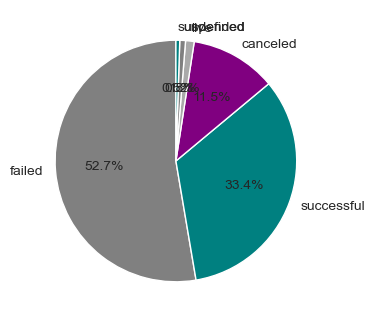

In [72]:
plt.pie(porcentaje4, labels=porcentaje4.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 5  (53-67 días)

In [73]:
duration_5.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59,27579.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55,18217.00


In [74]:
duration_5.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,41024.00000,41024.00000,41024.00000,41024.00000,41024.00000
mean,63.81642,6520.75925,146901.04646,58.66359,140380.28721
std,534.78900,81898.48309,2527066.92410,1.41221,2528341.64297
min,0.00000,0.00000,3.00000,53.00000,-9172055.66000
25%,1.00000,5.00000,3000.00000,59.00000,567.19000
50%,4.00000,150.00000,8000.00000,59.00000,5000.00000
75%,24.00000,1628.06000,25000.00000,59.00000,20718.75000
max,44949.00000,9192055.66000,110169771.62000,66.00000,110169769.42000


In [75]:
estados5 = duration_5.state.value_counts()
estados5

failed        25951
successful     8395
canceled       5311
live            680
undefined       368
suspended       319
Name: state, dtype: int64

In [76]:
total5 = duration_5.backers.count()

In [77]:
porcentaje5 = (estados5/total5)*100
porcentaje5

failed        63.258093
successful    20.463631
canceled      12.946080
live           1.657566
undefined      0.897036
suspended      0.777594
Name: state, dtype: float64

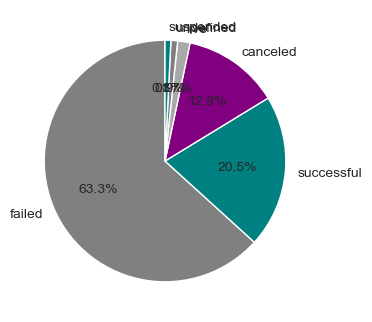

In [78]:
plt.pie(porcentaje5, labels=porcentaje5.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 6 (68-82 días)

In [79]:
duration_6.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
606,1002910237,Choose Your Fate - The film that puts YOU in c...,Film & Video,2010-08-16,2010-05-25 15:49:22,failed,10,US,547.8,3500.0,82,2952.2
747,1003596506,"New Madysin Hatter EP, To Be Titled ""Pretty Li...",Music,2010-12-01,2010-09-21 01:30:38,successful,30,US,2179.0,1800.0,70,-379.0
1146,1005824767,"ChileFornia- An anecdotal view of identity, im...",Journalism,2010-10-30,2010-08-18 21:03:40,failed,0,US,0.0,8000.0,72,8000.0


In [80]:
duration_6.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,1005.00000,1005.00000,1005.00000,1005.00000,1005.00000
mean,47.93134,3592.01330,9553.43178,74.29552,5961.41848
std,198.69430,14738.38559,18959.83759,4.30246,21485.02077
min,0.00000,0.00000,5.00000,68.00000,-354698.64000
25%,3.00000,100.00000,2000.00000,70.00000,-180.00000
50%,14.00000,800.33000,5000.00000,74.00000,1780.00000
75%,44.00000,3282.22000,10000.00000,78.00000,6500.00000
max,5258.00000,364698.64000,220000.00000,82.00000,219237.00000


In [81]:
estados6 = duration_6.state.value_counts()
estados6

failed        495
successful    392
canceled      118
Name: state, dtype: int64

In [82]:
total6 = duration_6.backers.count()

In [83]:
porcentaje6 = (estados6/total6)*100
porcentaje6

failed        49.253731
successful    39.004975
canceled      11.741294
Name: state, dtype: float64

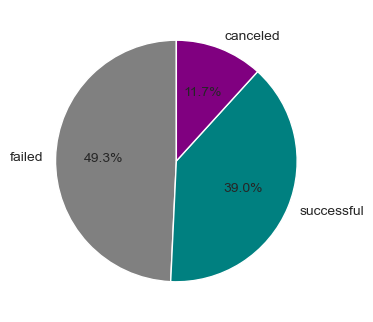

In [84]:
plt.pie(porcentaje6, labels=porcentaje6.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

### Grupo 7 (83-91 días)

In [85]:
duration_7.head(3)

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff
357,100162622,Circa Vitae requests crowd fundage to record o...,Music,2009-11-01,2009-08-06 23:19:55,failed,4,US,80.0,2000.0,86,1920.0
673,1003298216,JOHNNY STRANGE,Comics,2011-09-05,2011-06-07 08:57:37,failed,8,US,250.0,9000.0,89,8750.0
895,1004436383,Ten Animal Masks in 10 Weeks,Art,2010-05-29,2010-02-28 01:17:03,failed,13,US,421.0,2000.0,89,1579.0


In [86]:
duration_7.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff
count,2862.00000,2862.00000,2862.00000,2862.00000,2862.00000
mean,29.49686,2589.70751,48071.76801,88.55136,45482.06050
std,65.39898,7602.77412,805466.93793,1.47162,805580.15839
min,0.00000,0.00000,11.00000,83.00000,-133990.00000
25%,1.00000,30.00000,2500.00000,88.00000,-25.00000
50%,7.00000,369.50000,5000.00000,89.00000,3000.00000
75%,32.00000,2332.35500,10000.00000,89.00000,9648.50000
max,1495.00000,150456.00000,21474836.47000,91.00000,21474836.47000


In [87]:
estados7 = duration_7.state.value_counts()
estados7

failed        1652
successful     821
canceled       380
suspended        8
undefined        1
Name: state, dtype: int64

In [88]:
total7 = duration_7.backers.count()

In [89]:
porcentaje7 = (estados7/total7)*100
porcentaje7

failed        57.721873
successful    28.686233
canceled      13.277428
suspended      0.279525
undefined      0.034941
Name: state, dtype: float64

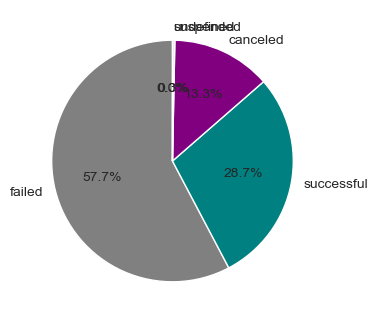

In [90]:
plt.pie(porcentaje7, labels=porcentaje7.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

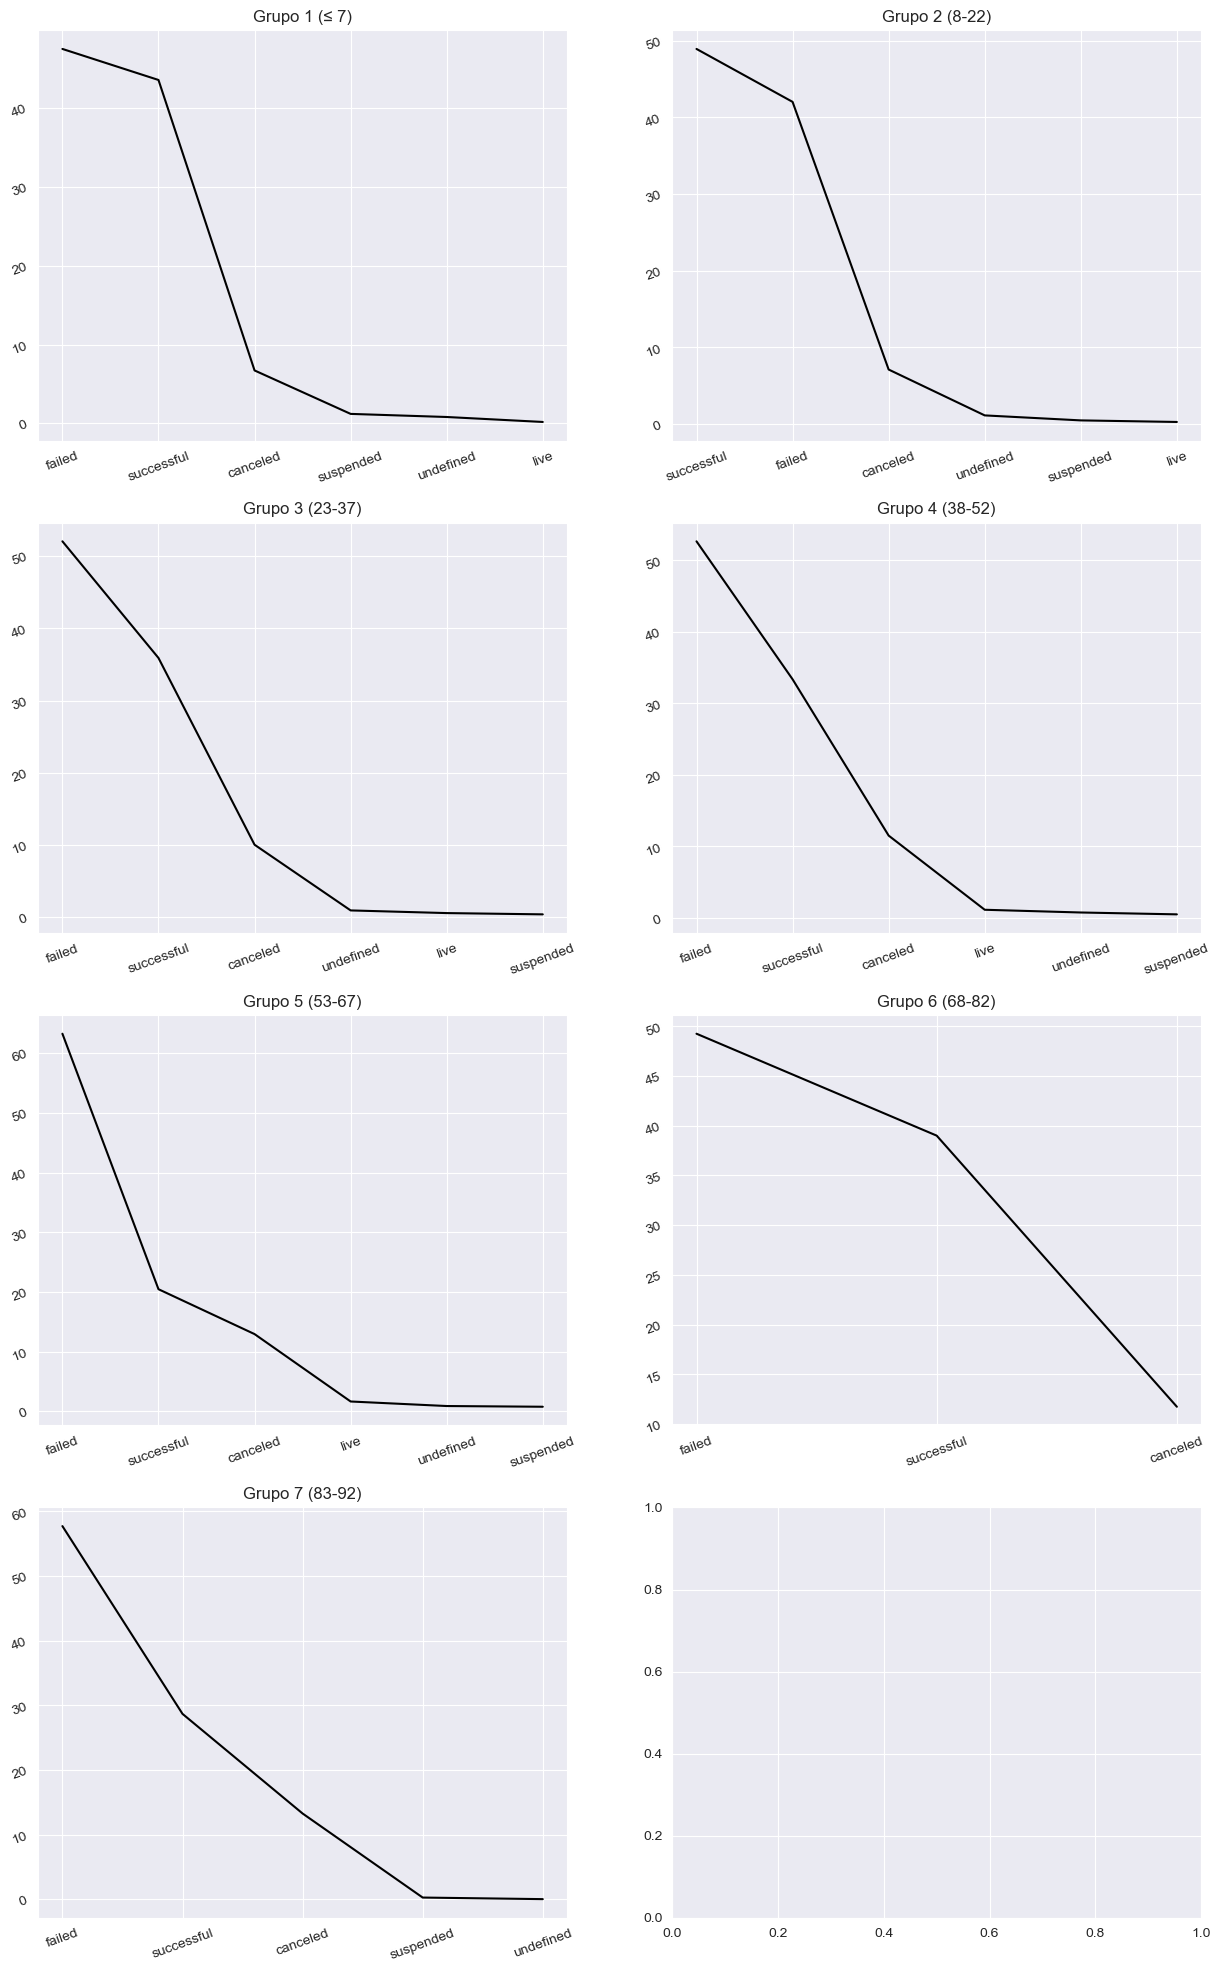

In [91]:
fig, axs = plt.subplots(ncols = 2, nrows = 4)
fig.set_figwidth(15)
fig.set_figheight(25)

axs[0,0].plot(porcentaje1, color = 'black')
axs[0,0].set_title('Grupo 1 (≤ 7)')
axs[0,0].tick_params(labelrotation=20)

axs[0,1].plot(porcentaje2, color = 'black')
axs[0,1].set_title('Grupo 2 (8-22)')
axs[0,1].tick_params(labelrotation=20)

axs[1,0].plot(porcentaje3, color = 'black')
axs[1,0].set_title('Grupo 3 (23-37)')
axs[1,0].tick_params(labelrotation=20)

axs[1,1].plot(porcentaje4, color = 'black')
axs[1,1].set_title('Grupo 4 (38-52)')
axs[1,1].tick_params(labelrotation=20)

axs[2,0].plot(porcentaje5, color = 'black')
axs[2,0].set_title('Grupo 5 (53-67)')
axs[2,0].tick_params(labelrotation=20)

axs[2,1].plot(porcentaje6, color = 'black')
axs[2,1].set_title('Grupo 6 (68-82)')
axs[2,1].tick_params(labelrotation=20)

axs[3,0].plot(porcentaje7, color = 'black')
axs[3,0].set_title('Grupo 7 (83-92)')
axs[3,0].tick_params(labelrotation=20);

## Algunas conclusiones

* Se coincide con el análisis de referencia en que la mayoría de las campañas caen en el grupo 3, con una duración entre 23 y 37 días.


* Sin embargo, en lo que respecta a los grupos 6 y 7 revisados, las campañas con estado de fracaso son 49.3 y 57.7 por ciento respectivamente. 


* En los grupos 2 y 3, las campañas fallidas fueron 42 y 52 por ciento respectivamente.


* En lo que respecta a campañas canceladas en los grupos 6 y 7 se tiene que estan representan 11.7 y 13.3 respectivamente.


* El porcentaje de campañas canceladas es menor para los grupos 1 y 2.


* Por su lado, las campañas exitosas en cada grupo se distribuyen de la siguiente manera:

        * Grupo 1 - 43.6 %
        * Grupo 2 - 48.9 %
        * Grupo 3 - 35.9 %
        * Grupo 4 - 33.4 %
        * Grupo 5 - 20.5 %
        * Grupo 6 - 39.0 %
        * Grupo 7 - 28.7 %

De los grupos 1 al 5 se observa una aparente relación que indica que conforme aumenta el tiempo de duración de la campaña aumenta, el porcentaje de éxito disminuye, sin embargo, este aparente patrón se rompe al considerar los grupos 6 y 7.

Los resultados no son compatibles con los obtenidos por el estudio de referencia.

**No se logró establecer alguna relación** clara entre la duración de la campaña y el grado de éxito.

## 2. ¿Cuál es la relación entre la meta del dinero a recaudar y el grado de éxito?

### a) Distribución de la meta con respecto al monto reunido.

De manera preliminar en el análisis de correlación se observa una relación fuerte entre la meta económica de la campaña y la diferencia entre esta y el monto recaudado. Sin embargo, continuaremos el análisis basado en la separación en grupos, pero ahora en base a los montos meta. La separación se llevará a cabo de la siguiente manera:

* Grupo 1: meta < 1,000

* Grupo 2: 1,000 < meta < 10,000

* Grupo 3: 10,000 < meta < 100,00

* Grupo 4: meta > 100,000

In [92]:
data.describe()

,backers,pledged,goal,duration,diff
count,377983.000000,3.779830e+05,3.779830e+05,377983.000000,3.779830e+05
mean,105.734869,9.064150e+03,4.524016e+04,33.216817,3.617601e+04
std,907.949887,9.094380e+04,1.142357e+06,12.779236,1.145457e+06
min,0.000000,0.000000e+00,2.230000e+00,1.000000,-1.983899e+07
25%,2.000000,3.100000e+01,2.000000e+03,29.000000,-2.000000e+02
50%,12.000000,6.250000e+02,5.500000e+03,29.000000,1.980000e+03
75%,56.000000,4.053005e+03,1.557444e+04,36.000000,9.999000e+03
max,219382.000000,2.033899e+07,1.663614e+08,91.000000,1.663614e+08


Es necesario tomar en cuenta los montos meta y su estado así como el porcentaje de la meta reunido. Creamos una columna que indique esta última característica.

In [93]:
data = data >> dfply.mutate(percent = (data.pledged / data.goal)*100)

In [94]:
data.head()

,ID,name,category,deadline,launched,state,backers,country,pledged,goal,duration,diff,percent
0,1000002330,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58,1533.95,0.000000
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59,27579.00,8.070000
2,1000004038,Where is Hank?,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44,44780.00,0.488889
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29,4999.00,0.020000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55,18217.00,6.579487


Ahora configuramos los distintos grupos:

In [95]:
meta_1 = data >> dfply.mask(data.goal <= 1000)
meta_2 = data >> dfply.mask((data.goal > 1000) & (data.goal <= 10000))
meta_3 = data >> dfply.mask((data.goal > 10000) & (data.goal <= 100000))
meta_4 = data >> dfply.mask(data.goal > 100000)

## Grupo 1

In [96]:
meta_1.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff,percent
count,60371.00000,60371.00000,60371.00000,60371.00000,60371.00000,60371.00000
mean,24.02006,863.24078,580.72888,29.11245,-282.51189,297.18642
std,99.96353,4201.48599,314.87780,13.18601,4189.57108,9980.20918
min,0.00000,0.00000,2.23000,1.00000,-364538.00000,0.00000
25%,1.00000,15.00000,310.54500,23.00000,-176.51500,3.19945
50%,7.00000,227.00000,522.00000,29.00000,9.29000,80.50000
75%,22.00000,866.26000,900.00000,29.00000,500.00000,138.19920
max,7857.00000,365538.00000,1000.00000,91.00000,1000.00000,2303606.70000


In [97]:
estado1 = meta_1.state.value_counts()
estado1

successful    29484
failed        25560
canceled       4389
suspended       501
live            432
undefined         5
Name: state, dtype: int64

In [98]:
total_1 = meta_1.backers.count()
total_1

60371

In [99]:
porcen1 = (estado1/total_1)*100
porcen1

successful    48.838018
failed        42.338209
canceled       7.270047
suspended      0.829869
live           0.715575
undefined      0.008282
Name: state, dtype: float64

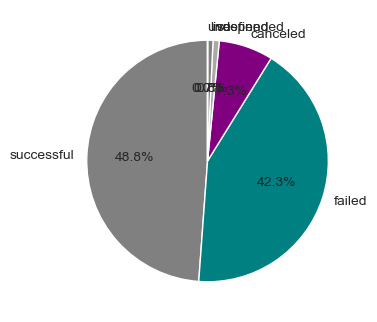

In [100]:
plt.pie(porcen1, labels = porcen1.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

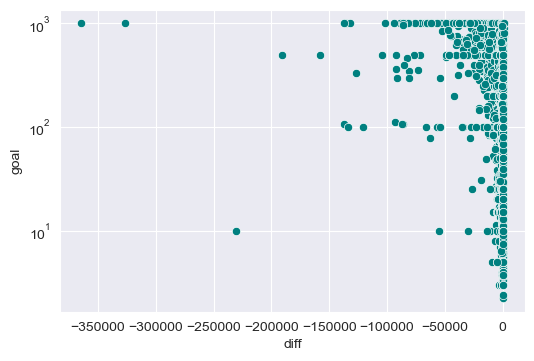

In [101]:
sns.scatterplot(y = meta_1.goal, x = meta_1['diff'], color = 'teal')
plt.yscale('log');

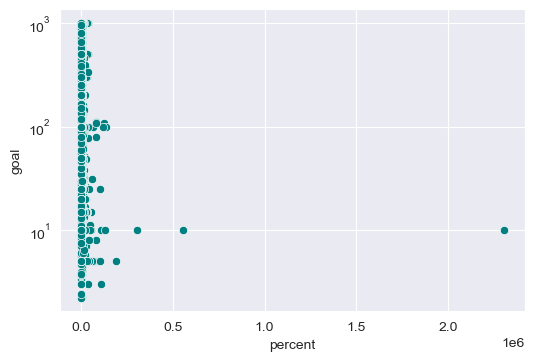

In [102]:
sns.scatterplot(y = meta_1.goal, x = meta_1.percent, color = 'teal')
plt.yscale('log');

## Grupo 2

In [103]:
meta_2.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff,percent
count,193211.00000,193211.00000,193211.00000,193211.00000,193211.00000,193211.00000
mean,65.52532,3790.43443,4826.88894,33.06948,1036.45451,80.45081
std,633.17078,27340.77901,2751.22785,12.76515,27261.94452,348.64308
min,0.00000,0.00000,1000.10000,1.00000,-8772571.99000,0.00000
25%,2.00000,45.38500,2500.00000,29.00000,-279.40500,1.05000
50%,14.00000,843.00000,4500.00000,29.00000,1844.00000,20.20000
75%,58.00000,4020.00000,6932.03500,35.00000,4890.00000,107.62804
max,219382.00000,8782571.99000,10000.00000,91.00000,10000.00000,87825.71990


In [104]:
estado2 = meta_2.state.value_counts()
estado2

failed        95864
successful    75668
canceled      16047
undefined      3546
live           1365
suspended       721
Name: state, dtype: int64

In [105]:
total_2 = meta_2.backers.count()
total_2

193211

In [106]:
porcen2 = (estado2/total_2)*100
porcen2

failed        49.616223
successful    39.163402
canceled       8.305428
undefined      1.835299
live           0.706482
suspended      0.373167
Name: state, dtype: float64

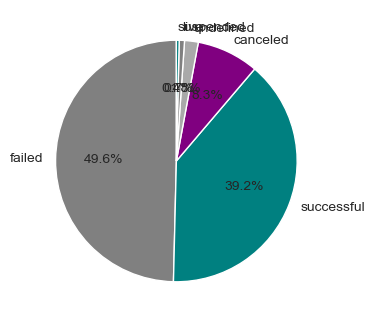

In [107]:
plt.pie(porcen2, labels = porcen2.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

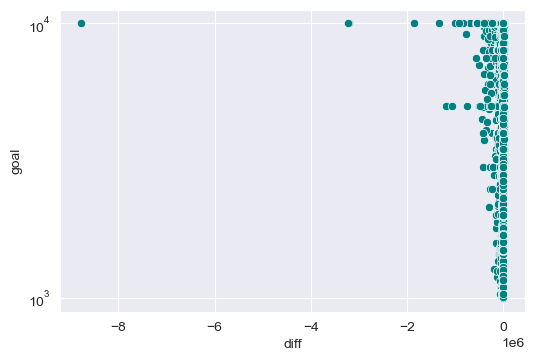

In [108]:
sns.scatterplot(y = meta_2.goal, x = meta_2['diff'], color = 'teal')
plt.yscale('log');

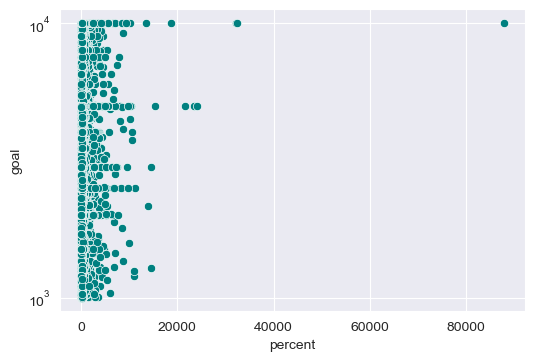

In [109]:
sns.scatterplot(y = meta_2.goal, x = meta_2.percent, color = 'teal')
plt.yscale('log');

## Grupo 3

In [110]:
meta_3.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff,percent
count,111721.00000,111721.00000,111721.00000,111721.00000,111721.00000,111721.00000
mean,187.40259,18948.29504,32034.71724,35.09333,13086.42220,64.55325
std,1001.87603,118971.21557,22159.07317,11.86170,119154.23496,343.47663
min,0.00000,0.00000,10001.00000,1.00000,-13235226.36000,0.00000
25%,2.00000,45.00000,15000.00000,29.00000,0.00000,0.15455
50%,15.00000,1203.00000,25000.00000,29.00000,17325.00000,4.63000
75%,116.00000,14400.81000,40000.00000,39.00000,32684.00000,100.00000
max,154926.00000,13285226.36000,100000.00000,91.00000,100000.00000,45960.27830


In [111]:
estado3 = meta_3.state.value_counts()
estado3

failed        67167
successful    27597
canceled      15545
live            891
suspended       510
undefined        11
Name: state, dtype: int64

In [112]:
total_3 = meta_3.backers.count()
total_3

111721

In [113]:
porcen3 = (estado3/total_3)*100
porcen3

failed        60.120300
successful    24.701712
canceled      13.914125
live           0.797522
suspended      0.456494
undefined      0.009846
Name: state, dtype: float64

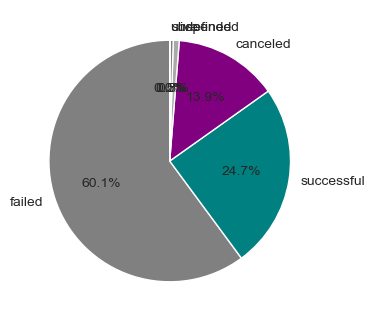

In [114]:
plt.pie(porcen3, labels = porcen3.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

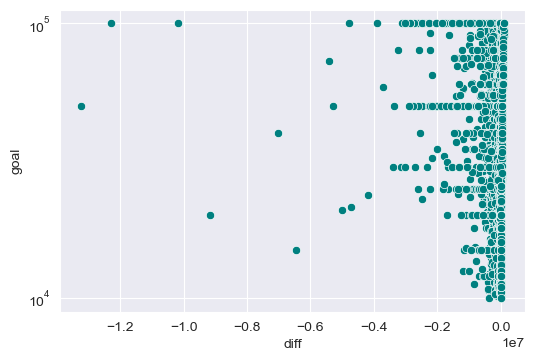

In [115]:
sns.scatterplot(y = meta_3.goal, x = meta_3['diff'], color = 'teal')
plt.yscale('log');

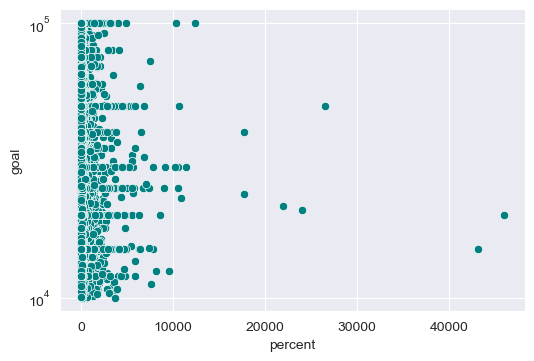

In [116]:
sns.scatterplot(y = meta_3.goal, x = meta_3.percent, color = 'teal')
plt.yscale('log');

## Grupo 4

In [117]:
meta_4.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,backers,pledged,goal,duration,diff,percent
count,12680.00000,12680.00000,12680.00000,12680.00000,12680.00000,12680.00000
mean,387.92192,41380.41721,990015.31190,38.46964,948634.89469,16.39992
std,3062.64072,328211.55760,6162025.62640,13.36391,6173818.98621,93.11009
min,0.00000,0.00000,100001.00000,1.00000,-19838986.27000,0.00000
25%,1.00000,1.00000,150000.00000,29.00000,131648.02000,0.00020
50%,3.00000,115.00000,200699.21500,30.00000,199950.00000,0.04310
75%,24.00000,3372.50000,400000.00000,49.00000,389607.00000,1.59312
max,105857.00000,20338986.27000,166361390.71000,91.00000,166361390.71000,4067.79725


In [118]:
estado4 = meta_4.state.value_counts()
estado4

failed        9018
canceled      2723
successful     734
live           104
suspended      101
Name: state, dtype: int64

In [119]:
total_4 = meta_4.backers.count()
total_4

12680

In [120]:
porcen4 = (estado4/total_4)*100
porcen4

failed        71.119874
canceled      21.474763
successful     5.788644
live           0.820189
suspended      0.796530
Name: state, dtype: float64

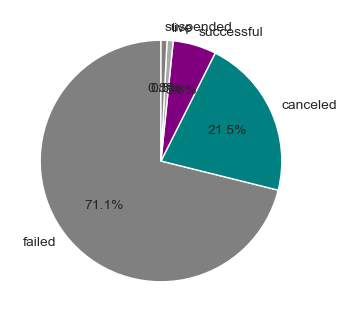

In [121]:
plt.pie(porcen4, labels = porcen4.index, autopct='%1.1f%%', startangle=90, 
        colors = ['gray', 'teal', 'purple', 'darkgray']);

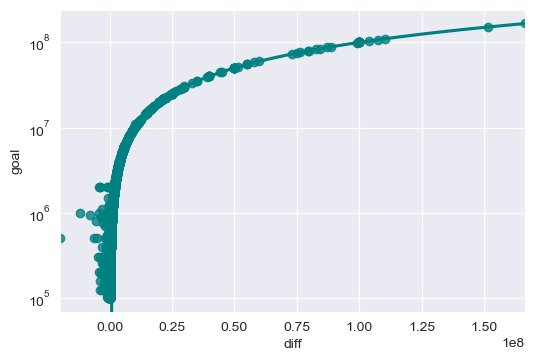

In [122]:
sns.regplot(y = meta_4.goal, x = meta_4['diff'], color = 'teal')
plt.yscale('log');

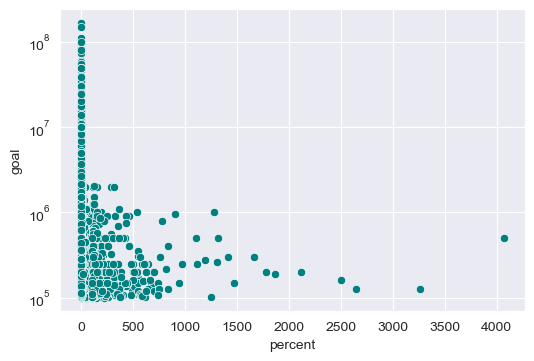

In [123]:
sns.scatterplot(y = meta_4.goal, x = meta_4.percent, color = 'teal')
plt.yscale('log');

## Algunas conclusiones

* Se coincide con el análisis de referencia en que en el grupo 1 se observan mas valores de diferencia negativos que en el grupo 4, el cual tiene mas valores de diferencia positivos, sin embargo, el grupo 3 con respecto al grupo 2 tiene una tendencia a presentar muchos más valores negativos en la diferencia entre meta económica y monto recaudado. 


* En los grupos 3 y 4 las campañas con estatus de fracaso representan 60.1 y 71.1 por ciento respectivamente.


* En los grupos 1 y 2, las campañas fallidas fueron 42.3 y 49.6 por ciento respectivamente.


* En lo que respecta a campañas canceladas en los grupos 3 y 4 se tiene que estan representan 13.9 y 21.5 respectivamente.


* El porcentaje de campañas canceladas es considerablemente menos para los grupos 1 y 2.


* Para el grupo 4 es evidente en la gráfica de diferencia contra meta que a medida que la meta económica aumenta la diferencia también lo hace en una especie de curva exponencial.


* Por su lado, las campañas exitosas en cada grupo se distribuyen de la siguiente manera:

        * Grupo 1 - 48.8 %
        * Grupo 2 - 39.2 %
        * Grupo 3 - 24.7 %
        * Grupo 4 - 5.8 %    

En este caso se puede ver una relación más clara entre la meta económica de la campaña y su grado de éxito. Tiene sentido que independientemente de la duración u otras características de las campañas, resulte más difícil recaudar grandes sumas de dinero. 

Los resultados son hasta cierto punto compatibles con los obtenidos por el estudio de referencia.

**Se observa una relación** entre la meta económica de la campaña y el grado de éxito. Confirmando de esta manera lo previsto por el análisis en matríz de correlación.

Recreamos la curva de diferencia contra meta pero con todos los datos del conjunto.

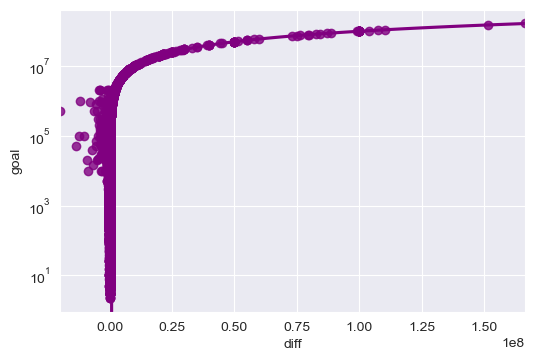

In [124]:
sns.regplot(y = data.goal, x = data['diff'], color = 'purple')
plt.yscale('log');

Se confirma el comportamiento y la relación que indica que entre mayor es la meta de reacaudación más difícil es llegar a ella.

## Conclusiones generales

En lo que respecta a la duración de las campañas el tiempo óptimo se encuentra en el rango entre 8 y 22 días, ya que este grupo es el que presentó en promedio mayor porcentaje de éxito que el resto de los grupos analizados. Las campañas más largas tienden a tener menor grado de éxito. En lo que respecta al monto a recaudar, las campañas menores a 1,000 USD presentan mayor grado de éxito mientras que las campañas mayores a 100,000 USD tienen muy pocas posibilidades de ser exitosas. Los hallazgos tienen sentido y se considera entonces que existe un rango de duración y meta económica en el cual se maximiza la posibilidad de éxito y por el contrario un rango en el cual casi es asegurado el fracaso.

In [125]:
exito = duration_2 >> dfply.mask(duration_2.goal < 1000)
estados = exito.state.value_counts()
total = exito.backers.count()

In [126]:
prueba = (estados/total) * 100
prueba

successful    59.626866
failed        33.498134
canceled       5.792910
suspended      0.764925
live           0.307836
undefined      0.009328
Name: state, dtype: float64

Con este pequeño ejercicio se puede ver que de las campañas que duran entre 8 y 22 días y además tienen una meta menor a 1,000 USD casi el 60% resultan exitosas.